In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim



In [2]:
# Config
TRAIN_DIR = "DIV2K_train_HR"
VAL_DIR = "DIV2K_valid_HR"
image_size = 128
scale_factor = 2
batch_size = 8
epochs = 50
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
class SRDataset(Dataset):
    def __init__(self, root_dir):
        self.image_paths = sorted([
            os.path.join(root_dir, img) for img in os.listdir(root_dir)
            if img.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        print(f"Loaded {len(self.image_paths)} images from {root_dir}")

        self.hr_transform = transforms.Compose([
            transforms.CenterCrop(image_size),
            transforms.ToTensor()
        ])
        self.lr_transform = transforms.Compose([
            transforms.CenterCrop(image_size),
            transforms.Resize(image_size // scale_factor, interpolation=Image.BICUBIC),
            transforms.Resize(image_size, interpolation=Image.BICUBIC),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        hr = self.hr_transform(img)
        lr = self.lr_transform(img)
        return lr, hr, os.path.basename(self.image_paths[idx])

# Load datasets right after class
train_dataset = SRDataset(TRAIN_DIR)
val_dataset = SRDataset(VAL_DIR)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Loaded 800 images from DIV2K_train_HR
Loaded 100 images from DIV2K_valid_HR


In [8]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=5, padding=2)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize model, criterion, optimizer
model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [9]:
def evaluate(model, dataloader, log=True):
    model.eval()
    total_loss = 0
    total_psnr = 0
    total_ssim = 0
    criterion = nn.MSELoss()

    with torch.no_grad():
        for lr, hr, _ in dataloader:
            lr, hr = lr.to(device), hr.to(device)
            sr = model(lr)
            loss = criterion(sr, hr)
            total_loss += loss.item()

            sr_np = sr.cpu().numpy()
            hr_np = hr.cpu().numpy()
            for i in range(sr_np.shape[0]):
                sr_img = np.transpose(sr_np[i], (1, 2, 0))
                hr_img = np.transpose(hr_np[i], (1, 2, 0))
                total_psnr += compare_psnr(hr_img, sr_img, data_range=1.0)
                total_ssim += compare_ssim(hr_img, sr_img, data_range=1.0, win_size=7, channel_axis=-1)

    n = len(dataloader.dataset)
    return total_loss / len(dataloader), total_psnr / n, total_ssim / n


In [ ]:
def train(model, dataloader, criterion, optimizer, val_loader):
    model.train()
    os.makedirs("checkpoints", exist_ok=True)
    train_losses, val_losses, psnrs, ssims = [], [], [], []

    for epoch in range(epochs):
        start_time = time.time()
        total_loss = 0
        model.train()

        for lr, hr, _ in dataloader:
            lr, hr = lr.to(device), hr.to(device)
            optimizer.zero_grad()
            sr = model(lr)
            loss = criterion(sr, hr)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_loss, psnr, ssim = evaluate(model, val_loader)
        epoch_time = time.time() - start_time

        train_losses.append(total_loss / len(dataloader))
        val_losses.append(val_loss)
        psnrs.append(psnr)
        ssims.append(ssim)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"| Time: {epoch_time:.2f}s "
              f"| Train Loss: {train_losses[-1]:.4f} "
              f"| Val Loss: {val_loss:.4f} "
              f"| PSNR: {psnr:.2f} "
              f"| SSIM: {ssim:.4f}")

        if (epoch + 1) % 5 == 0:
            checkpoint_path = f"checkpoints/srcnn_epoch_{epoch+1}.pth"
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Saved checkpoint: {checkpoint_path}")

    return train_losses, val_losses, psnrs, ssims

# Start training immediately
train_losses, val_losses, psnrs, ssims = train(model, train_loader, criterion, optimizer, val_loader)


Epoch [1/50] | Time: 176.88s | Train Loss: 0.0499 | Val Loss: 0.0091 | PSNR: 21.51 | SSIM: 0.6674
Epoch [2/50] | Time: 236.66s | Train Loss: 0.0066 | Val Loss: 0.0046 | PSNR: 24.92 | SSIM: 0.7716
Epoch [3/50] | Time: 239.39s | Train Loss: 0.0041 | Val Loss: 0.0035 | PSNR: 26.45 | SSIM: 0.8092
Epoch [4/50] | Time: 212.82s | Train Loss: 0.0035 | Val Loss: 0.0032 | PSNR: 27.10 | SSIM: 0.8262
Epoch [5/50] | Time: 240.40s | Train Loss: 0.0032 | Val Loss: 0.0031 | PSNR: 27.21 | SSIM: 0.8359
[INFO] Saved checkpoint: checkpoints/srcnn_epoch_5.pth
Epoch [6/50] | Time: 213.76s | Train Loss: 0.0030 | Val Loss: 0.0028 | PSNR: 27.82 | SSIM: 0.8445
Epoch [7/50] | Time: 236.31s | Train Loss: 0.0028 | Val Loss: 0.0027 | PSNR: 27.99 | SSIM: 0.8508
Epoch [8/50] | Time: 235.79s | Train Loss: 0.0028 | Val Loss: 0.0027 | PSNR: 27.85 | SSIM: 0.8547
Epoch [9/50] | Time: 211.96s | Train Loss: 0.0027 | Val Loss: 0.0025 | PSNR: 28.33 | SSIM: 0.8582
Epoch [10/50] | Time: 234.49s | Train Loss: 0.0026 | Val Loss: 

[INFO] Plotting training metrics...


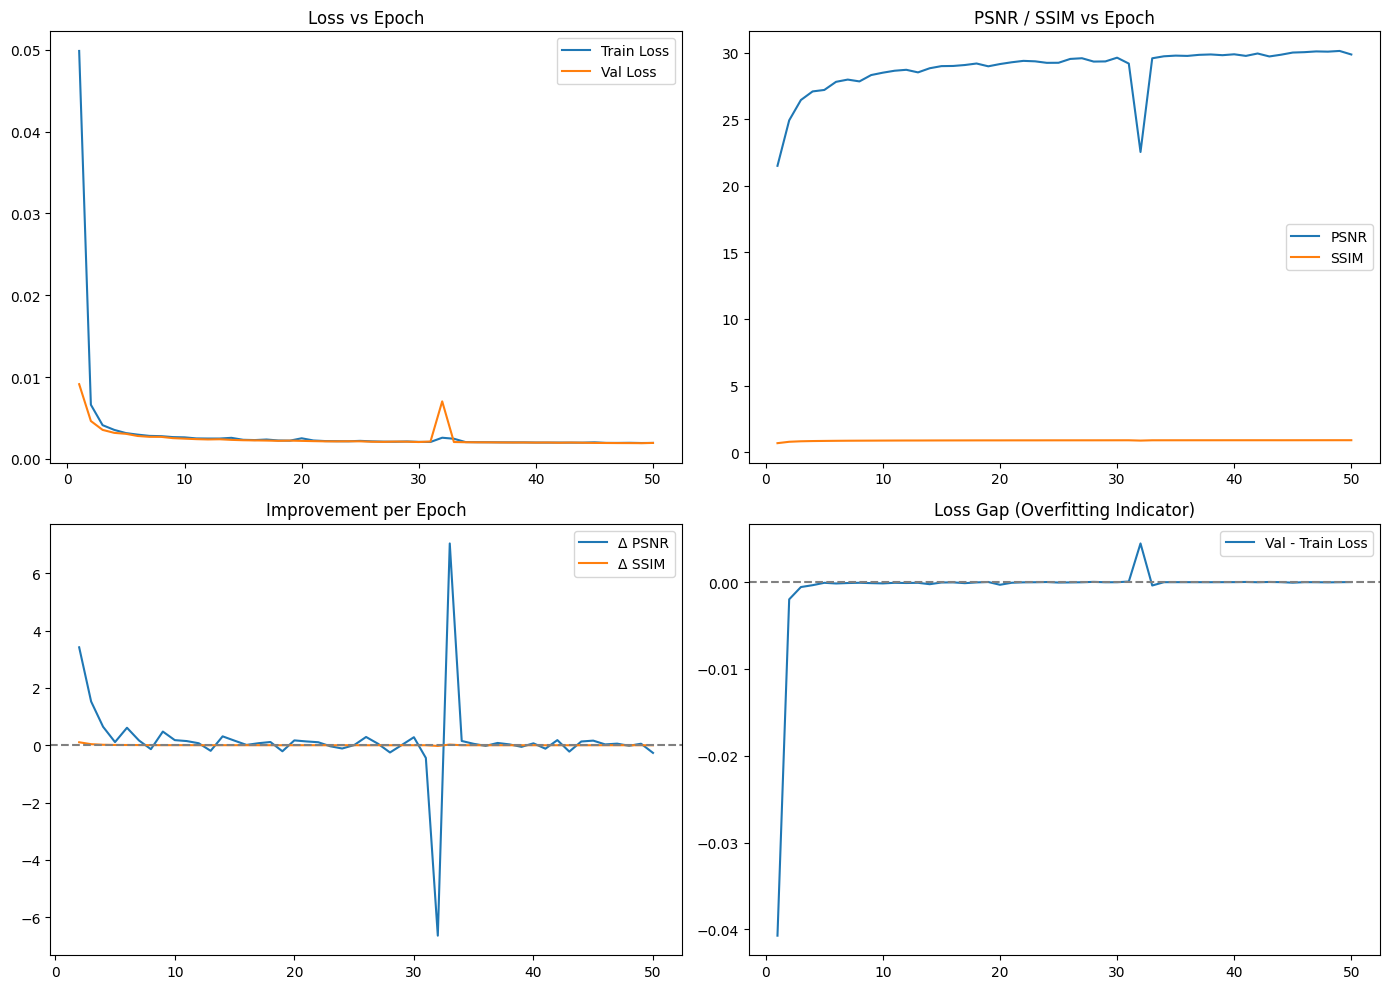

[INFO] Saved plot to results/metrics.png


In [ ]:
def plot_metrics(train_losses, val_losses, psnrs, ssims):

    os.makedirs("results", exist_ok=True)
    print("Plotting training metrics...")

    epochs = len(train_losses)
    epochs_range = range(1, epochs + 1)

    psnr_deltas = [j - i for i, j in zip(psnrs[:-1], psnrs[1:])]
    ssim_deltas = [j - i for i, j in zip(ssims[:-1], ssims[1:])]
    loss_gaps = [v - t for t, v in zip(train_losses, val_losses)]

    plt.figure(figsize=(14, 10))

    # Plot 1: Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.legend()
    plt.title("Loss vs Epoch")

    # Plot 2: PSNR and SSIM
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, psnrs, label='PSNR')
    plt.plot(epochs_range, ssims, label='SSIM')
    plt.legend()
    plt.title("PSNR / SSIM vs Epoch")

    # Plot 3: Delta Metrics
    plt.subplot(2, 2, 3)
    plt.plot(epochs_range[1:], psnr_deltas, label='Δ PSNR')
    plt.plot(epochs_range[1:], ssim_deltas, label='Δ SSIM')
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend()
    plt.title("Improvement per Epoch")

    # Plot 4: Loss Gap
    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, loss_gaps, label='Val - Train Loss')
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend()
    plt.title("Loss Gap (Overfitting Indicator)")

    plt.tight_layout()
    plt.savefig("results/metrics.png")
    plt.show()
    print("Saved plot to results/metrics.png")


# Call plotting function immediately
plot_metrics(train_losses, val_losses, psnrs, ssims)


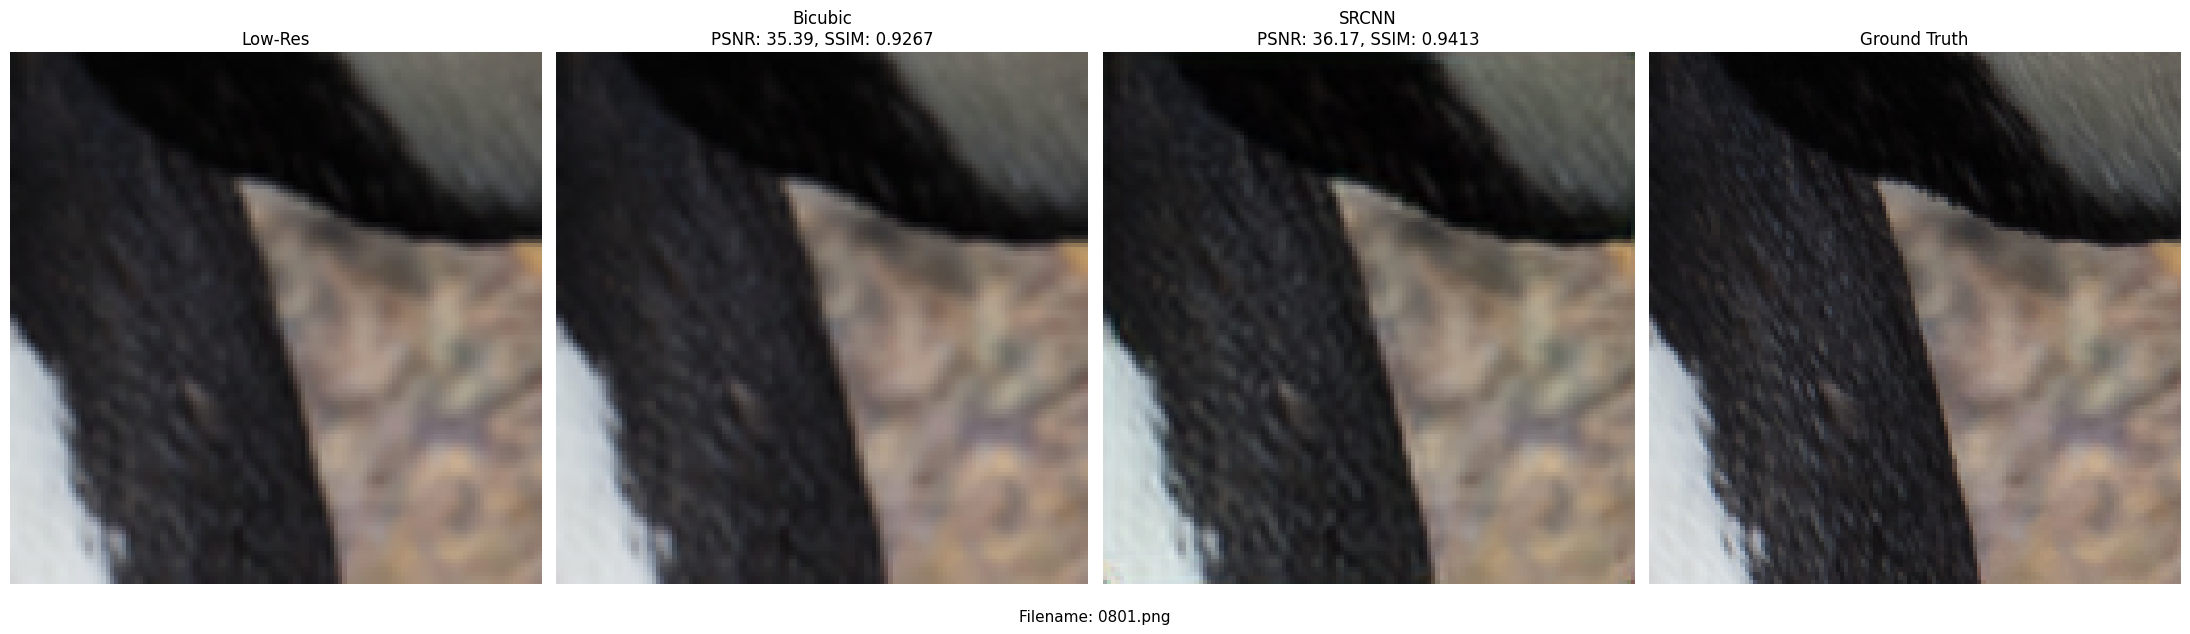

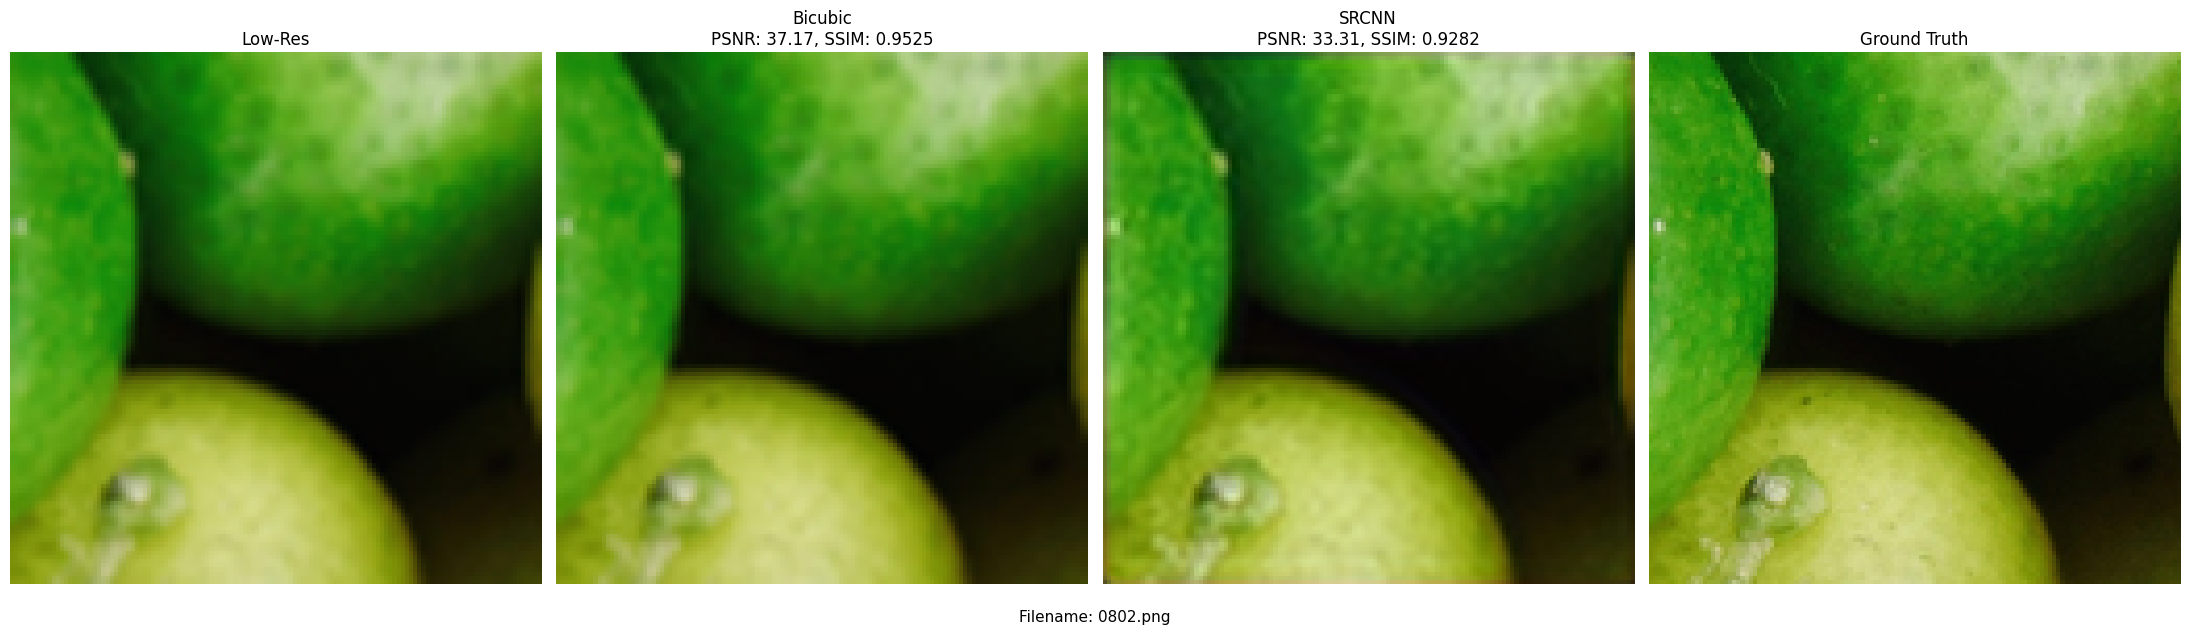

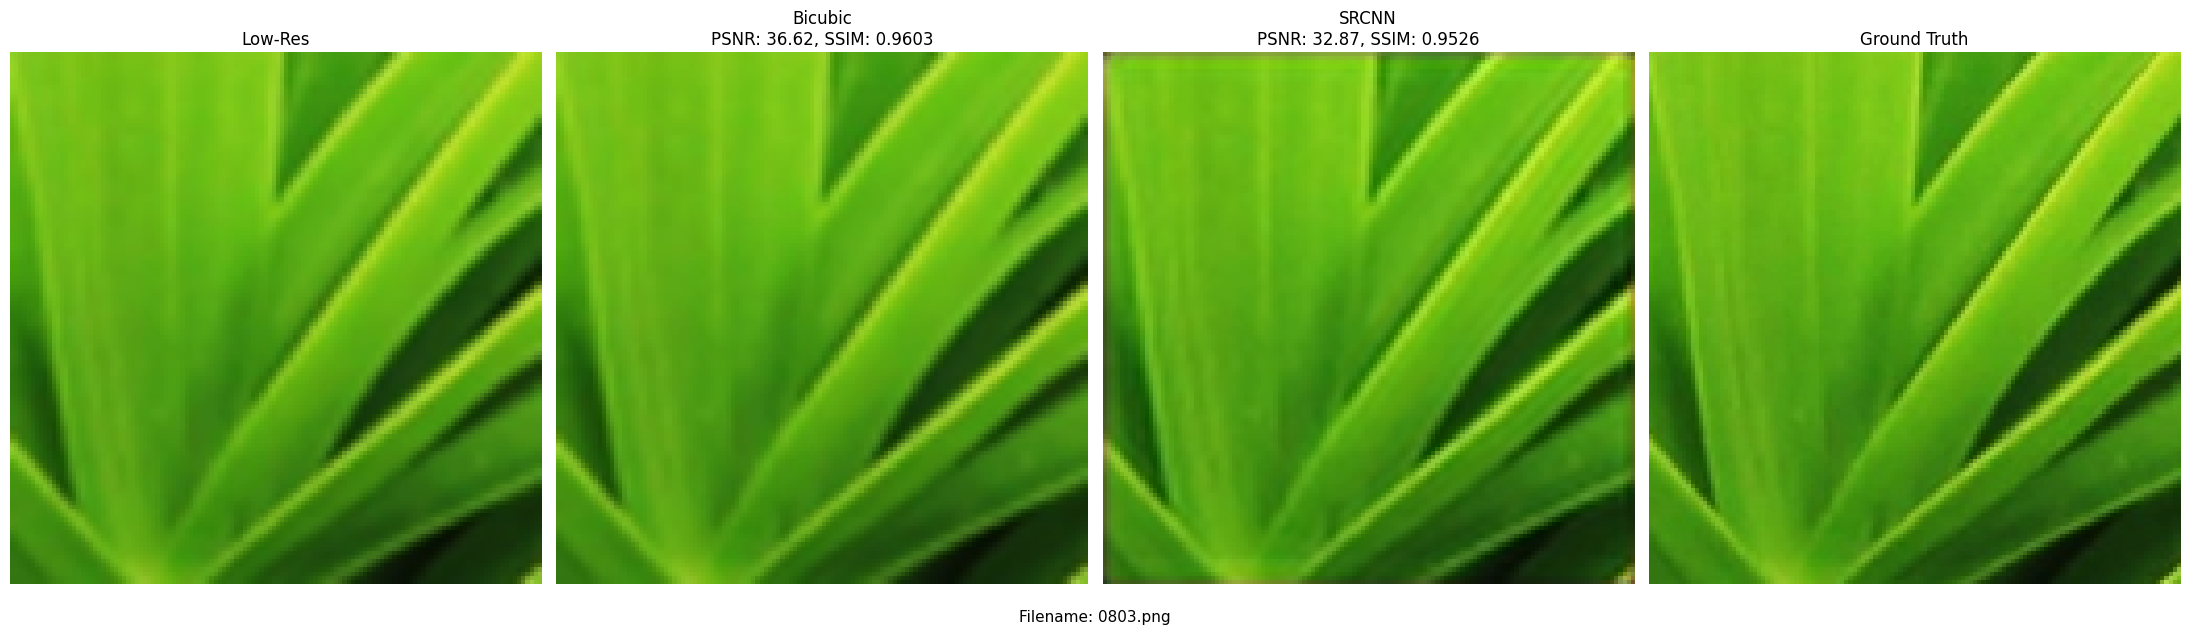

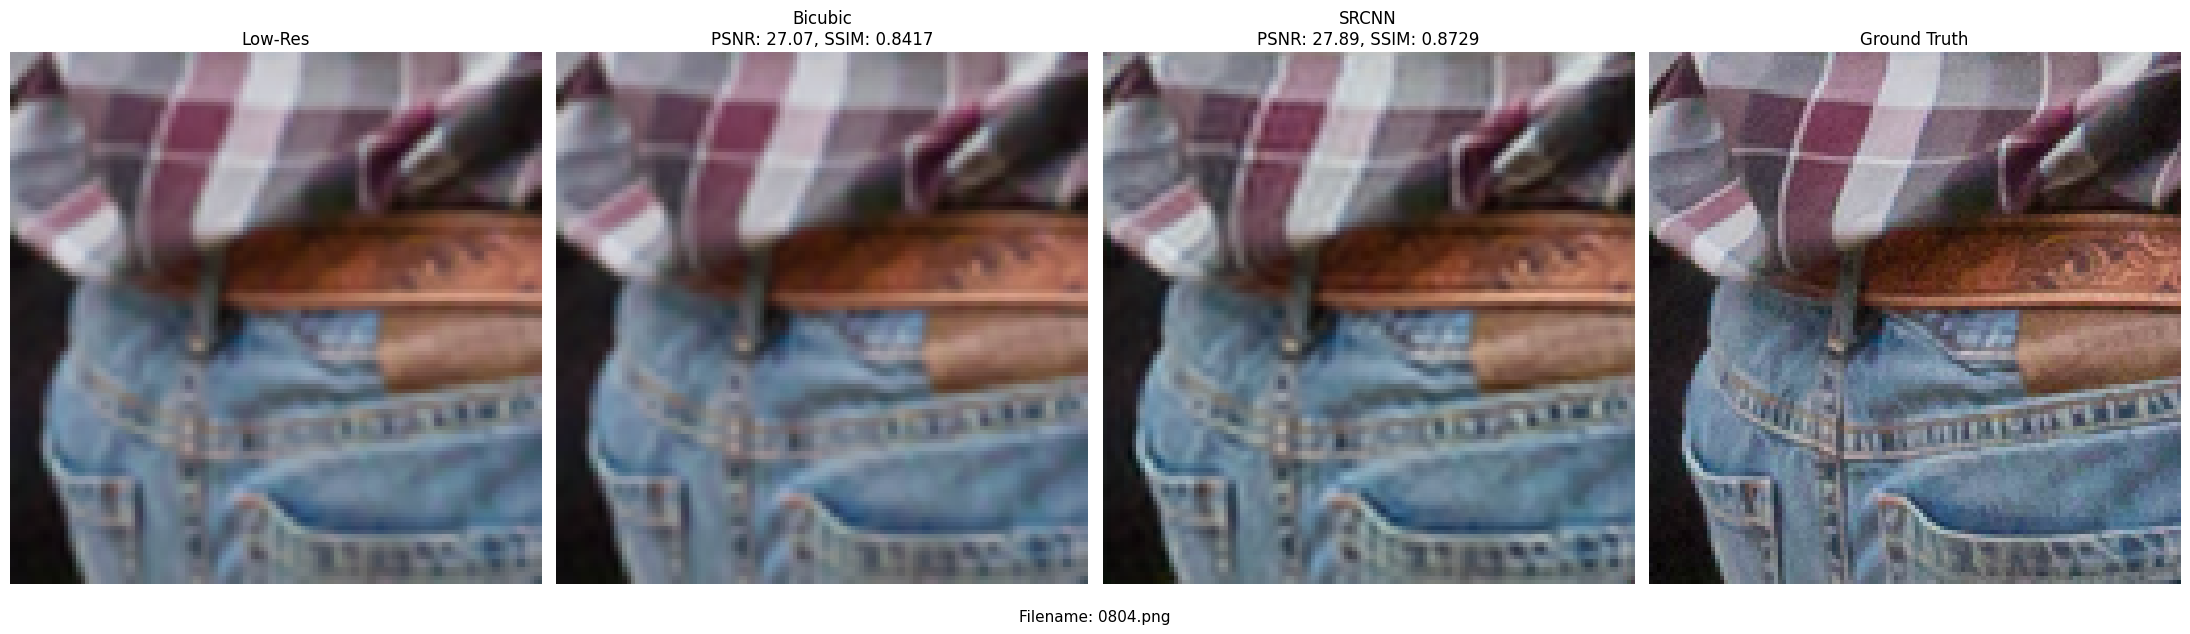

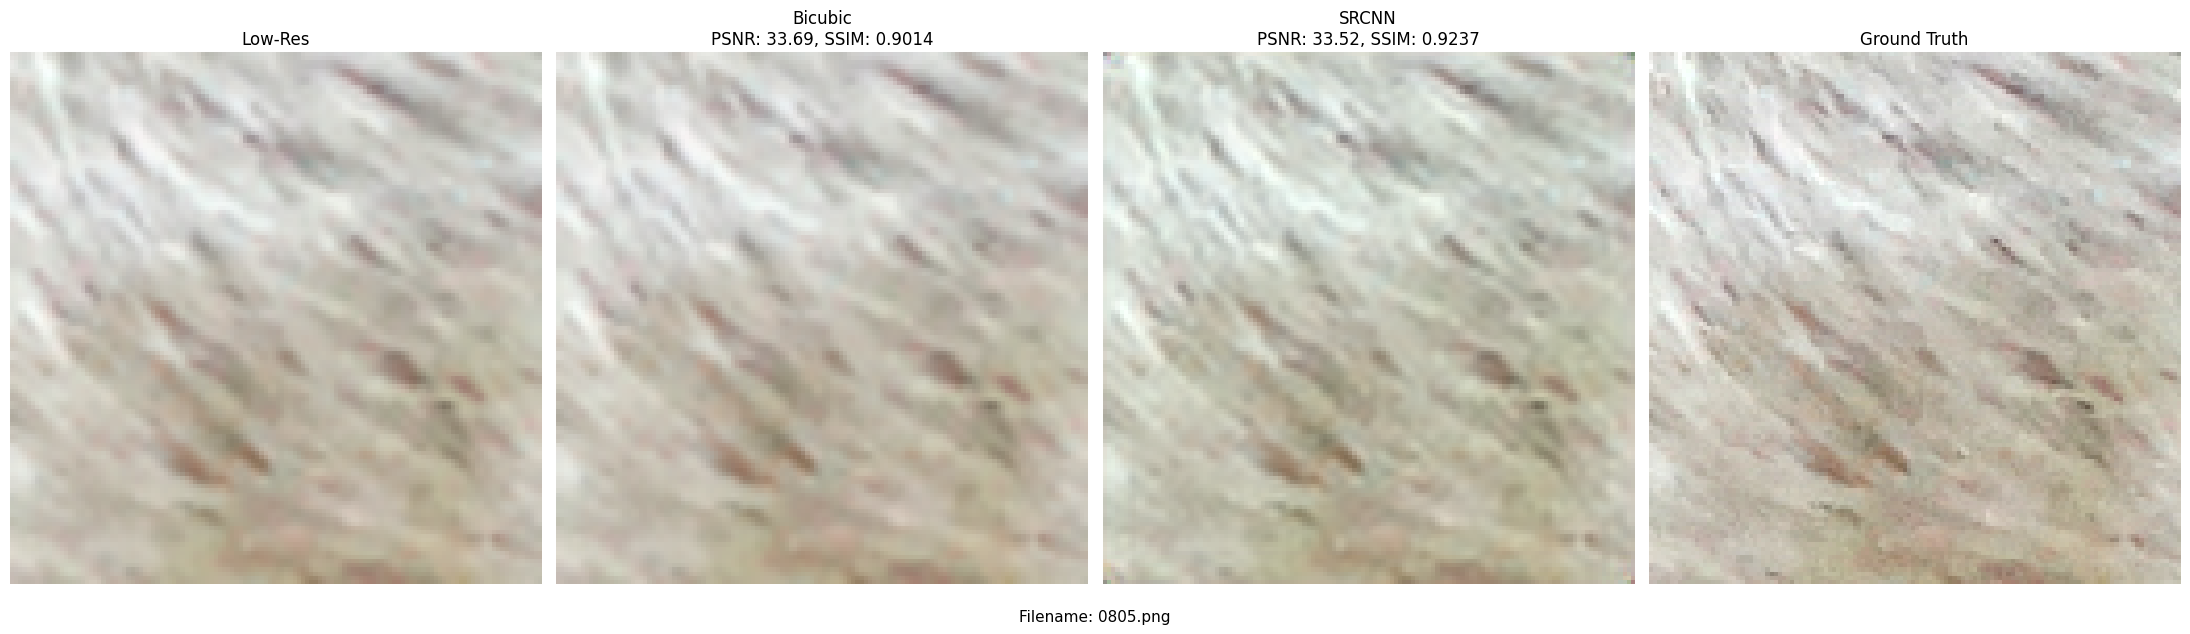

In [32]:


def visualize(model, dataset, num_images=5):
    model.eval()
    os.makedirs("results/comparisons", exist_ok=True)

    for i in range(num_images):
        lr, hr, filename = dataset[i]
        lr = lr.unsqueeze(0).to(device)
        
        with torch.no_grad():
            sr = model(lr).cpu().squeeze(0)

        # Convert tensors to PIL images
        lr_img = transforms.ToPILImage()(lr.squeeze(0).cpu().clamp(0, 1))
        hr_img = transforms.ToPILImage()(hr.clamp(0, 1))
        sr_img = transforms.ToPILImage()(sr.clamp(0, 1))

        # Resize LR image using bicubic for comparison
        bicubic = lr_img.resize((hr_img.width, hr_img.height), Image.BICUBIC)

        # Metrics
        psnr_bicubic = compare_psnr(np.array(hr_img), np.array(bicubic))
        ssim_bicubic = compare_ssim(np.array(hr_img), np.array(bicubic), channel_axis=-1)
        psnr_srcnn = compare_psnr(np.array(hr_img), np.array(sr_img))
        ssim_srcnn = compare_ssim(np.array(hr_img), np.array(sr_img), channel_axis=-1)

        # Plotting
        fig, axs = plt.subplots(1, 4, figsize=(22, 6))

        axs[0].imshow(lr_img)
        axs[0].set_title("Low-Res", fontsize=12)
        axs[0].axis("off")

        axs[1].imshow(bicubic)
        axs[1].set_title(f"Bicubic\nPSNR: {psnr_bicubic:.2f}, SSIM: {ssim_bicubic:.4f}", fontsize=12)
        axs[1].axis("off")

        axs[2].imshow(sr_img)
        axs[2].set_title(f"SRCNN\nPSNR: {psnr_srcnn:.2f}, SSIM: {ssim_srcnn:.4f}", fontsize=12)
        axs[2].axis("off")

        axs[3].imshow(hr_img)
        axs[3].set_title("Ground Truth", fontsize=12)
        axs[3].axis("off")

        # Add filename below entire row
        plt.figtext(0.5, 0.01, f"Filename: {filename}", ha="center", fontsize=11)

        # Save & show
        plt.tight_layout(rect=[0, 0.03, 1, 1])  # leave space at bottom
        plt.savefig(f"results/comparisons/{filename}")
        plt.show()
visualize(model, val_dataset, num_images=5)


##IMPLEMENTING ESPCN MODEL

In [ ]:
import os
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim


In [ ]:
class ESPCN(nn.Module):
    def __init__(self, scale_factor=2):
        super(ESPCN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.Tanh(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.Conv2d(32, 3 * (scale_factor ** 2), kernel_size=3, padding=1)
        )
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.pixel_shuffle(x)
        return x


In [ ]:
scale_factor = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ESPCN(scale_factor=scale_factor).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
# def calculate_metrics(sr, hr):
#     sr = sr.detach().cpu().numpy().transpose(1, 2, 0)
#     hr = hr.detach().cpu().numpy().transpose(1, 2, 0)
#     sr = sr.clip(0, 1)
#     hr = hr.clip(0, 1)
#     psnr = psnr_metric(hr, sr, data_range=1.0)
#     ssim = ssim_metric(hr, sr, multichannel=True, data_range=1.0)
#     return psnr, ssim


In [ ]:
def train(model, train_loader, val_loader, epochs=50):
    train_losses, val_losses, psnrs, ssims = [], [], [], []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        start_time = time.time()

        for lr, hr, _ in train_loader:
            lr, hr = lr.to(device), hr.to(device)
            optimizer.zero_grad()
            sr = model(lr)
            loss = criterion(sr, hr)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        epoch_val_loss = 0
        psnr_total, ssim_total = 0, 0

        with torch.no_grad():
            for lr, hr, _ in val_loader:
                lr, hr = lr.to(device), hr.to(device)
                sr = model(lr)
                loss = criterion(sr, hr)
                epoch_val_loss += loss.item()

                for i in range(sr.size(0)):
                    sr_img = sr[i].cpu().clamp(0, 1)
                    hr_img = hr[i].cpu().clamp(0, 1)
                    psnr = compare_psnr(hr_img.permute(1, 2, 0).numpy(), sr_img.permute(1, 2, 0).numpy())
                    ssim = compare_ssim(hr_img.permute(1, 2, 0).numpy(), sr_img.permute(1, 2, 0).numpy(), channel_axis=-1)
                    psnr_total += psnr
                    ssim_total += ssim

        avg_val_loss = epoch_val_loss / len(val_loader)
        avg_psnr = psnr_total / (len(val_loader.dataset))
        avg_ssim = ssim_total / (len(val_loader.dataset))

        val_losses.append(avg_val_loss)
        psnrs.append(avg_psnr)
        ssims.append(avg_ssim)

        elapsed = time.time() - start_time
        print(f"Epoch [{epoch+1}/{epochs}] | Time: {elapsed:.2f}s | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"PSNR: {avg_psnr:.2f} | SSIM: {avg_ssim:.4f}")

    return train_losses, val_losses, psnrs, ssims


In [ ]:
def plot_metrics(train_losses, val_losses, psnrs, ssims):
    epochs = range(1, len(train_losses)+1)
    os.makedirs("results_espcn", exist_ok=True)

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss vs Epoch")

    plt.subplot(2, 2, 2)
    plt.plot(epochs, psnrs, label="PSNR")
    plt.plot(epochs, ssims, label="SSIM")
    plt.legend()
    plt.title("PSNR / SSIM vs Epoch")

    plt.subplot(2, 2, 3)
    plt.plot(epochs[1:], np.diff(psnrs), label="Δ PSNR")
    plt.plot(epochs[1:], np.diff(ssims), label="Δ SSIM")
    plt.axhline(0, color="gray", linestyle="--")
    plt.legend()
    plt.title("Improvement per Epoch")

    plt.subplot(2, 2, 4)
    gap = np.array(val_losses) - np.array(train_losses)
    plt.plot(epochs, gap, label="Val - Train Loss")
    plt.axhline(0, color="gray", linestyle="--")
    plt.legend()
    plt.title("Loss Gap")

    plt.tight_layout()
    plt.savefig("results_espcn/metrics.png")
    plt.show()


In [ ]:
def visualize(model, dataset, num_images=5):
    model.eval()
    os.makedirs("results_espcn/comparisons", exist_ok=True)

    for i in range(num_images):
        lr, hr, filename = dataset[i]
        lr = lr.unsqueeze(0).to(device)

        with torch.no_grad():
            sr = model(lr).cpu().squeeze(0)

        lr_img = transforms.ToPILImage()(lr.squeeze(0).cpu().clamp(0, 1))
        hr_img = transforms.ToPILImage()(hr.clamp(0, 1))
        sr_img = transforms.ToPILImage()(sr.clamp(0, 1))
        bicubic = lr_img.resize(hr_img.size, Image.BICUBIC)

        psnr_bicubic = compare_psnr(np.array(hr_img), np.array(bicubic))
        ssim_bicubic = compare_ssim(np.array(hr_img), np.array(bicubic), channel_axis=-1)
        psnr_espcn = compare_psnr(np.array(hr_img), np.array(sr_img))
        ssim_espcn = compare_ssim(np.array(hr_img), np.array(sr_img), channel_axis=-1)

        fig, axs = plt.subplots(1, 4, figsize=(22, 6))
        axs[0].imshow(lr_img)
        axs[0].set_title("Low-Res")
        axs[0].axis("off")

        axs[1].imshow(bicubic)
        axs[1].set_title(f"Bicubic\nPSNR: {psnr_bicubic:.2f}, SSIM: {ssim_bicubic:.4f}")
        axs[1].axis("off")

        axs[2].imshow(sr_img)
        axs[2].set_title(f"ESPCN\nPSNR: {psnr_espcn:.2f}, SSIM: {ssim_espcn:.4f}")
        axs[2].axis("off")

        axs[3].imshow(hr_img)
        axs[3].set_title("Ground Truth")
        axs[3].axis("off")

        plt.figtext(0.5, 0.01, f"Filename: {filename}", ha="center")
        plt.tight_layout(rect=[0, 0.03, 1, 1])
        plt.savefig(f"results_espcn/comparisons/{filename}")
        plt.show()


In [ ]:
def visualize_comparison(lr, sr_espcn, sr_srcnn, hr):
    def convert(img): return img.detach().cpu().squeeze(0).permute(1,2,0).numpy().clip(0, 1)

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(convert(lr)); axs[0].set_title('Low-Res')
    axs[1].imshow(convert(sr_srcnn)); axs[1].set_title('SRCNN')
    axs[2].imshow(convert(sr_espcn)); axs[2].set_title('ESPCN')
    axs[3].imshow(convert(hr)); axs[3].set_title('Ground Truth')
    for ax in axs: ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
print("SRCNN Final PSNR:", srcnn_psnr_list[-1])
print("ESPCN Final PSNR:", espcn_psnr_list[-1])
print("SRCNN Final SSIM:", srcnn_ssim_list[-1])
print("ESPCN Final SSIM:", espcn_ssim_list[-1])


In [ ]:
# Run this after both models are trained
lr, hr = next(iter(val_loader))
lr, hr = lr.to(device), hr.to(device)
sr_srcnn = srcnn_model(lr)
sr_espcn = model(lr)
visualize_comparison(lr[0].unsqueeze(0), sr_espcn[0].unsqueeze(0), sr_srcnn[0].unsqueeze(0), hr[0].unsqueeze(0))


##VDSR

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import time
import os
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim


In [ ]:
class VDSR(nn.Module):
    def __init__(self):
        super(VDSR, self).__init__()
        self.input = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.hidden = nn.Sequential(
            *[nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True)) for _ in range(18)]
        )
        self.output = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.hidden(out)
        out = self.output(out)
        return residual + out

In [ ]:
def train_vdsr(model, train_loader, val_loader, epochs=50, lr=0.001):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses, psnrs, ssims, times = [], [], [], [], []

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_start = time.time()
        total_loss = 0

        for lr, hr, _ in train_loader:
            lr = lr[:, 0:1, :, :].to(device)  # Grayscale
            hr = hr[:, 0:1, :, :].to(device)

            optimizer.zero_grad()
            sr = model(lr)
            loss = criterion(sr, hr)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        psnr_total = 0
        ssim_total = 0

        with torch.no_grad():
            for lr, hr, _ in val_loader:
                lr = lr[:, 0:1, :, :].to(device)
                hr = hr[:, 0:1, :, :].to(device)
                sr = model(lr)

                val_loss += criterion(sr, hr).item()

                for i in range(sr.size(0)):
                    pred = sr[i].cpu().squeeze().numpy()
                    gt = hr[i].cpu().squeeze().numpy()
                    psnr_total += compare_psnr(gt, pred)
                    ssim_total += compare_ssim(gt, pred)

        avg_val_loss = val_loss / len(val_loader)
        avg_psnr = psnr_total / len(val_loader.dataset)
        avg_ssim = ssim_total / len(val_loader.dataset)

        val_losses.append(avg_val_loss)
        psnrs.append(avg_psnr)
        ssims.append(avg_ssim)

        elapsed = time.time() - epoch_start
        times.append(elapsed)

        print(f"Epoch [{epoch}/{epochs}] | Time: {elapsed:.2f}s | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | PSNR: {avg_psnr:.2f} | SSIM: {avg_ssim:.4f}")

    return train_losses, val_losses, psnrs, ssims, times

In [ ]:
def plot_vdsr_metrics(train_losses, val_losses, psnrs, ssims, times):
    os.makedirs("results", exist_ok=True)
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.title("Loss vs Epoch")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, psnrs, label="PSNR")
    plt.plot(epochs, ssims, label="SSIM")
    plt.title("PSNR / SSIM vs Epoch")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, times, label="Time per Epoch (s)")
    plt.title("Time per Epoch")
    plt.legend()

    plt.tight_layout()
    plt.savefig("results/vdsr_metrics.png")
    plt.show()


In [ ]:
from torchvision.transforms.functional import to_pil_image

def visualize_vdsr(model, dataset, num_images=5):
    model.eval()
    os.makedirs("results/vdsr_comparisons", exist_ok=True)

    for i in range(num_images):
        lr, hr, filename = dataset[i]
        lr_tensor = lr[0:1].unsqueeze(0).to(device)

        with torch.no_grad():
            sr = model(lr_tensor).cpu().squeeze().clamp(0, 1)

        lr_img = to_pil_image(lr[0])
        hr_img = to_pil_image(hr[0])
        sr_img = to_pil_image(sr)

        bicubic = lr_img.resize(hr_img.size, resample=Image.BICUBIC)

        psnr_b = compare_psnr(np.array(hr_img), np.array(bicubic))
        ssim_b = compare_ssim(np.array(hr_img), np.array(bicubic))
        psnr_v = compare_psnr(np.array(hr_img), np.array(sr_img))
        ssim_v = compare_ssim(np.array(hr_img), np.array(sr_img))

        fig, axs = plt.subplots(1, 4, figsize=(22, 6))
        axs[0].imshow(lr_img, cmap='gray')
        axs[0].set_title("Low-Res")

        axs[1].imshow(bicubic, cmap='gray')
        axs[1].set_title(f"Bicubic\nPSNR: {psnr_b:.2f}, SSIM: {ssim_b:.4f}")

        axs[2].imshow(sr_img, cmap='gray')
        axs[2].set_title(f"VDSR\nPSNR: {psnr_v:.2f}, SSIM: {ssim_v:.4f}")

        axs[3].imshow(hr_img, cmap='gray')
        axs[3].set_title("Ground Truth")

        for ax in axs:
            ax.axis("off")

        plt.figtext(0.5, 0.01, f"Filename: {filename}", ha="center")
        plt.tight_layout(rect=[0, 0.03, 1, 1])
        plt.savefig(f"results/vdsr_comparisons/{filename}")
        plt.show()
